# Introduction

## Final Project Submission

***
- Student Name: Adam Marianacci
- Student Pace: Flex
- Scheduled project review date/time: 11/29/2023 11:00am
- Instructor Name: Abhineet Kulkarni

# Business Understanding

Coldwell Banker wants to buy undervalued homes in certain zipcodes to minimally renovate and sell for a profit. It is my job to find homes that are being listed significanty lower than the median price and look into what variables are causing these lowered prices so that I can properly advise Coldwell Banker on which homes to target. 

# Data Understanding

This project uses the King County House Sales dataset. It contains over 30,000 entries of data related to the sale price of houses, number of bedrooms,bathrooms and floors, square footage, addresses, and more. The main dataframe used in this project only contained roughly 14,000 entries. A limitation of the data was that it is fairly small since we are dealing with predictive modeling. Also the features of the data were strongly correlated with each other (multicolinearity) rather than the target variable. The dataset is suitable for this project because it has information to reveal which homes are truly being undervalued in certain zipcodes. After analyzing the price, location, and other various specifications and amenities of homes I will be able to make informed recommendations to the real estate agency.

# Data Preperation

I started by importing the necessary libraries.

In [1]:
import pandas as pd
import re
import numpy as np
from sklearn import linear_model
from sklearn.feature_selection import RFE
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
import seaborn as sns
import matplotlib.pyplot as plt
import statsmodels.api as sm
import scipy.stats as stats
import warnings
warnings.filterwarnings('ignore')

I did not want any information in the dataframe to be truncated. I searched `pandas output truncated` in google and found this [solution](https://stackoverflow.com/questions/25351968/how-can-i-display-full-non-truncated-dataframe-information-in-html-when-conver).

In [2]:
pd.set_option("max_columns", None) # show all cols
pd.set_option('max_colwidth', None) # show full width of showing cols
pd.set_option("expand_frame_repr", False) # print cols side by side as it's supposed to be
pd.set_option('display.max_rows', 500) #show all rows
pd.options.display.float_format = '{:.2f}'.format #surpressing scientific notation

In [3]:
# Loading the dataframe
kc_house_data_df = pd.read_csv('data/kc_house_data.csv', index_col=0)

In [4]:
# Previewing the dataframe
kc_house_data_df.head()

,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,greenbelt,nuisance,view,condition,grade,heat_source,sewer_system,sqft_above,sqft_basement,sqft_garage,sqft_patio,yr_built,yr_renovated,address,lat,long
id,,,,,,,,,,,,,,,,,,,,,,,,
7399300360,5/24/2022,675000.00,4,1.00,1180,7140,1.00,NO,NO,NO,NONE,Good,7 Average,Gas,PUBLIC,1180,0,0,40,1969,0,"2102 Southeast 21st Court, Renton, Washington 98055, United States",47.46,-122.19
8910500230,12/13/2021,920000.00,5,2.50,2770,6703,1.00,NO,NO,YES,AVERAGE,Average,7 Average,Oil,PUBLIC,1570,1570,0,240,1950,0,"11231 Greenwood Avenue North, Seattle, Washington 98133, United States",47.71,-122.36
1180000275,9/29/2021,311000.00,6,2.00,2880,6156,1.00,NO,NO,NO,AVERAGE,Average,7 Average,Gas,PUBLIC,1580,1580,0,0,1956,0,"8504 South 113th Street, Seattle, Washington 98178, United States",47.50,-122.23
1604601802,12/14/2021,775000.00,3,3.00,2160,1400,2.00,NO,NO,NO,AVERAGE,Average,9 Better,Gas,PUBLIC,1090,1070,200,270,2010,0,"4079 Letitia Avenue South, Seattle, Washington 98118, United States",47.57,-122.29
8562780790,8/24/2021,592500.00,2,2.00,1120,758,2.00,NO,NO,YES,NONE,Average,7 Average,Electricity,PUBLIC,1120,550,550,30,2012,0,"2193 Northwest Talus Drive, Issaquah, Washington 98027, United States",47.53,-122.07


There are 24 columns and 30155 entries. There is only a handful of missing values in the "heat_source" and "sewer_system" columns. The data types consist of objects, integers, and floats.

In [5]:
# Gathering information about the datatypes within the dataframe,as well as looking for missing values
kc_house_data_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 30155 entries, 7399300360 to 9557800100
Data columns (total 24 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   date           30155 non-null  object 
 1   price          30155 non-null  float64
 2   bedrooms       30155 non-null  int64  
 3   bathrooms      30155 non-null  float64
 4   sqft_living    30155 non-null  int64  
 5   sqft_lot       30155 non-null  int64  
 6   floors         30155 non-null  float64
 7   waterfront     30155 non-null  object 
 8   greenbelt      30155 non-null  object 
 9   nuisance       30155 non-null  object 
 10  view           30155 non-null  object 
 11  condition      30155 non-null  object 
 12  grade          30155 non-null  object 
 13  heat_source    30123 non-null  object 
 14  sewer_system   30141 non-null  object 
 15  sqft_above     30155 non-null  int64  
 16  sqft_basement  30155 non-null  int64  
 17  sqft_garage    30155 non-null  int64

I wanted to confirm and see clearly how many missing values there were in each column.

In [6]:
kc_house_data_df.isnull().sum()

date              0
price             0
bedrooms          0
bathrooms         0
sqft_living       0
sqft_lot          0
floors            0
waterfront        0
greenbelt         0
nuisance          0
view              0
condition         0
grade             0
heat_source      32
sewer_system     14
sqft_above        0
sqft_basement     0
sqft_garage       0
sqft_patio        0
yr_built          0
yr_renovated      0
address           0
lat               0
long              0
dtype: int64

Since there were only 32 missing values from "heat_source" and 14 missing values from "sewer_system" out of 30,155 entries, I decided to remove the rows that contained missing values. I typed `remove rows that contain missing values in a  pandas df` into google and found this [solution](https://stackoverflow.com/questions/13413590/how-to-drop-rows-of-pandas-dataframe-whose-value-in-a-certain-column-is-nan).

In [7]:
kc_house_data_df = kc_house_data_df.dropna(subset = ["heat_source", "sewer_system",])

Checking to see if my code worked, there are no more missing values.

In [8]:
kc_house_data_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 30111 entries, 7399300360 to 9557800100
Data columns (total 24 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   date           30111 non-null  object 
 1   price          30111 non-null  float64
 2   bedrooms       30111 non-null  int64  
 3   bathrooms      30111 non-null  float64
 4   sqft_living    30111 non-null  int64  
 5   sqft_lot       30111 non-null  int64  
 6   floors         30111 non-null  float64
 7   waterfront     30111 non-null  object 
 8   greenbelt      30111 non-null  object 
 9   nuisance       30111 non-null  object 
 10  view           30111 non-null  object 
 11  condition      30111 non-null  object 
 12  grade          30111 non-null  object 
 13  heat_source    30111 non-null  object 
 14  sewer_system   30111 non-null  object 
 15  sqft_above     30111 non-null  int64  
 16  sqft_basement  30111 non-null  int64  
 17  sqft_garage    30111 non-null  int64

"Lat", "Long", did not seem relevant since I am looking into zipcodes. I dropped them from the dataframe to simplify and condense the df.

In [9]:
kc_house_data_df.drop(['lat', 'long',], axis=1, inplace=True)

I wanted to extract zipcodes from addresses so I searched `extracting zipcodes from addresses in python` and found this [solution](https://stackoverflow.com/questions/66384707/extracting-zip-code-from-a-string-with-full-address).

In [10]:
def extract_zipcode(address):
    zipcode = re.search(r'\b\d{5}\b', address)
    if zipcode:
        return zipcode.group(0)
    else:
        return None

# Create the "Zip Code" column by applying the function to the "address" column
kc_house_data_df['Zip Code'] = kc_house_data_df['address'].apply(extract_zipcode)

In [11]:
kc_house_data_df.head()

,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,greenbelt,nuisance,view,condition,grade,heat_source,sewer_system,sqft_above,sqft_basement,sqft_garage,sqft_patio,yr_built,yr_renovated,address,Zip Code
id,,,,,,,,,,,,,,,,,,,,,,,
7399300360,5/24/2022,675000.00,4,1.00,1180,7140,1.00,NO,NO,NO,NONE,Good,7 Average,Gas,PUBLIC,1180,0,0,40,1969,0,"2102 Southeast 21st Court, Renton, Washington 98055, United States",98055
8910500230,12/13/2021,920000.00,5,2.50,2770,6703,1.00,NO,NO,YES,AVERAGE,Average,7 Average,Oil,PUBLIC,1570,1570,0,240,1950,0,"11231 Greenwood Avenue North, Seattle, Washington 98133, United States",11231
1180000275,9/29/2021,311000.00,6,2.00,2880,6156,1.00,NO,NO,NO,AVERAGE,Average,7 Average,Gas,PUBLIC,1580,1580,0,0,1956,0,"8504 South 113th Street, Seattle, Washington 98178, United States",98178
1604601802,12/14/2021,775000.00,3,3.00,2160,1400,2.00,NO,NO,NO,AVERAGE,Average,9 Better,Gas,PUBLIC,1090,1070,200,270,2010,0,"4079 Letitia Avenue South, Seattle, Washington 98118, United States",98118
8562780790,8/24/2021,592500.00,2,2.00,1120,758,2.00,NO,NO,YES,NONE,Average,7 Average,Electricity,PUBLIC,1120,550,550,30,2012,0,"2193 Northwest Talus Drive, Issaquah, Washington 98027, United States",98027


After previewing the dataset again I noticed that it was interpreting 5 digit street addresses as zipcodes. To fix this problem I decided to choose the 5 digit numbers after the word "Washington".

In [12]:
# Function to extract ZIP code after "Washington"
def extract_zipcode(address):
    match = re.search(r'Washington (\d{5})', address)
    if match:
        return match.group(1)
    return None

kc_house_data_df['Zip Code'] = kc_house_data_df['address'].apply(extract_zipcode)

In [13]:
kc_house_data_df.head()

,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,greenbelt,nuisance,view,condition,grade,heat_source,sewer_system,sqft_above,sqft_basement,sqft_garage,sqft_patio,yr_built,yr_renovated,address,Zip Code
id,,,,,,,,,,,,,,,,,,,,,,,
7399300360,5/24/2022,675000.00,4,1.00,1180,7140,1.00,NO,NO,NO,NONE,Good,7 Average,Gas,PUBLIC,1180,0,0,40,1969,0,"2102 Southeast 21st Court, Renton, Washington 98055, United States",98055
8910500230,12/13/2021,920000.00,5,2.50,2770,6703,1.00,NO,NO,YES,AVERAGE,Average,7 Average,Oil,PUBLIC,1570,1570,0,240,1950,0,"11231 Greenwood Avenue North, Seattle, Washington 98133, United States",98133
1180000275,9/29/2021,311000.00,6,2.00,2880,6156,1.00,NO,NO,NO,AVERAGE,Average,7 Average,Gas,PUBLIC,1580,1580,0,0,1956,0,"8504 South 113th Street, Seattle, Washington 98178, United States",98178
1604601802,12/14/2021,775000.00,3,3.00,2160,1400,2.00,NO,NO,NO,AVERAGE,Average,9 Better,Gas,PUBLIC,1090,1070,200,270,2010,0,"4079 Letitia Avenue South, Seattle, Washington 98118, United States",98118
8562780790,8/24/2021,592500.00,2,2.00,1120,758,2.00,NO,NO,YES,NONE,Average,7 Average,Electricity,PUBLIC,1120,550,550,30,2012,0,"2193 Northwest Talus Drive, Issaquah, Washington 98027, United States",98027


Using the nunique function to find the number of zipcodes in the dataset which is 92.

In [14]:
unique_zipcodes = kc_house_data_df['Zip Code'].nunique()

In [15]:
unique_zipcodes

92

# Data Analysis

I started by running a df.describe() on the dataset to learn more about the descriptive statistics. I see that the mean of price is about 1.1 million and the median is 860,000, which means we do not have a normal distribution and it is right skewed. The majority of the data is located on the left side of the graph.

In [16]:
kc_house_data_df.describe()

,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,sqft_above,sqft_basement,sqft_garage,sqft_patio,yr_built,yr_renovated
count,30111.00,30111.00,30111.00,30111.00,30111.00,30111.00,30111.00,30111.00,30111.00,30111.00,30111.00,30111.00
mean,1108970.65,3.42,2.34,2113.34,16648.80,1.54,1810.39,476.62,330.48,217.45,1975.16,90.79
std,896515.83,0.98,0.89,973.45,59933.03,0.57,877.73,579.81,285.73,245.30,32.05,416.20
min,27360.00,0.00,0.00,3.00,402.00,1.00,2.00,0.00,0.00,0.00,1900.00,0.00
25%,649236.00,3.00,2.00,1420.00,4850.00,1.00,1180.00,0.00,0.00,40.00,1953.00,0.00
50%,860000.00,3.00,2.50,1920.00,7477.00,1.50,1560.00,0.00,400.00,150.00,1977.00,0.00
75%,1300000.00,4.00,3.00,2620.00,10568.00,2.00,2270.00,940.00,510.00,320.00,2003.00,0.00
max,30750000.00,13.00,10.50,15360.00,3253932.00,4.00,12660.00,8020.00,3580.00,4370.00,2022.00,2022.00


I used a heatmap to see how the features were correlated with each other and found that price was correlated the highest with sqft_living.

<AxesSubplot:>

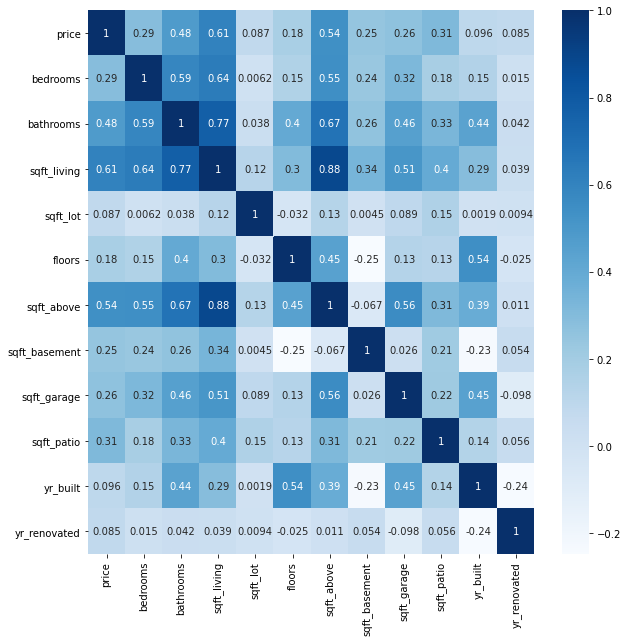

In [17]:
fig, ax = plt.subplots(figsize=(10,10))
cor = kc_house_data_df.corr()
sns.heatmap(cor,cmap="Blues",annot=True)

<AxesSubplot:xlabel='sqft_living', ylabel='price'>

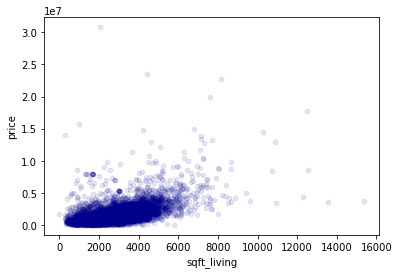

In [18]:
kc_house_data_df.plot.scatter(
    x='sqft_living',
    y='price',
    c='DarkBlue',
    alpha = 0.1)

I wanted to see how many zipcodes there were in the dataset and how many each contained so I ran a value_counts on "Zip Codes"

In [19]:
kc_house_data_df['Zip Code'].value_counts()

98042    992
98038    857
98103    761
98115    760
98117    748
98023    695
98034    689
98058    682
98133    664
98001    623
98092    609
98033    608
98118    600
98059    583
98052    568
98106    543
98031    530
98006    526
98056    520
98155    515
98125    489
98045    466
98107    458
98022    457
98126    440
98003    440
98122    440
98144    439
98146    428
98074    427
98198    425
98075    411
98199    410
98008    397
98053    393
98116    387
98178    383
98168    383
98027    382
98030    377
98002    363
98028    349
98040    349
98166    344
98072    343
98105    330
98004    322
98029    321
98010    314
98112    307
98108    305
98177    301
98136    299
98065    292
98011    261
98077    246
98019    245
98119    241
98055    218
98188    200
98070    191
98032    184
98005    178
98014    156
98007    154
98102    144
98109    129
98057    127
98024    114
98148     94
98047     77
98051     66
98039     59
98354     23
98288     16
98272      6
98271      5

After reviewing the counts, I decided to the drop the zipcodes that had under 100 houses listed to sale. I decided to keep the '98149' zipcode with a count of 94 because it was close.

In [20]:
# Count the occurrences of each ZIP code
zipcode_counts = kc_house_data_df['Zip Code'].value_counts()
kc_house_data_df = kc_house_data_df[kc_house_data_df['Zip Code'].isin(zipcode_counts[zipcode_counts >= 94].index)]


Checking to see if the Zip Codes below a count of 94 were dropped, they were!

In [21]:
kc_house_data_df['Zip Code'].value_counts()

98042    992
98038    857
98103    761
98115    760
98117    748
98023    695
98034    689
98058    682
98133    664
98001    623
98092    609
98033    608
98118    600
98059    583
98052    568
98106    543
98031    530
98006    526
98056    520
98155    515
98125    489
98045    466
98107    458
98022    457
98126    440
98122    440
98003    440
98144    439
98146    428
98074    427
98198    425
98075    411
98199    410
98008    397
98053    393
98116    387
98168    383
98178    383
98027    382
98030    377
98002    363
98040    349
98028    349
98166    344
98072    343
98105    330
98004    322
98029    321
98010    314
98112    307
98108    305
98177    301
98136    299
98065    292
98011    261
98077    246
98019    245
98119    241
98055    218
98188    200
98070    191
98032    184
98005    178
98014    156
98007    154
98102    144
98109    129
98057    127
98024    114
98148     94
Name: Zip Code, dtype: int64

I wanted to create a graph of median prices of homes by zipcode to get an idea of which zipcodes had the highest median price. To do this I used the sort_values function along with the median function. 

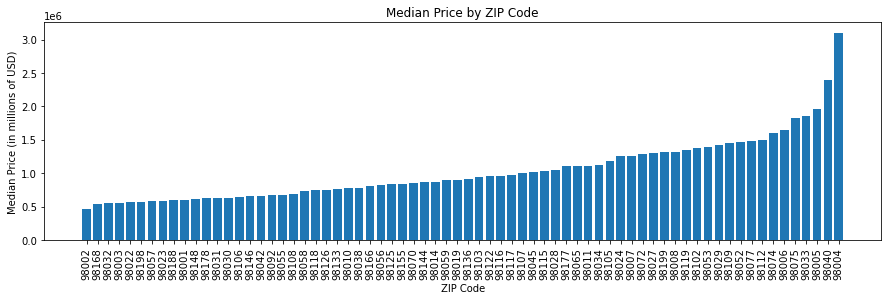

In [22]:
# Group data by ZIP code and calculate the median price from lowest to highest
median_prices = kc_house_data_df.groupby('Zip Code')['price'].median().sort_values().reset_index()

# Create a bar chart to visualize the median prices by ZIP code
plt.figure(figsize=(15, 4))
plt.bar(median_prices['Zip Code'], median_prices['price'])
plt.xlabel('ZIP Code')
plt.ylabel('Median Price (in millions of USD)')
plt.title('Median Price by ZIP Code')
# Label every data point on the X-axis
plt.xticks(range(len(median_prices)), median_prices['Zip Code'], rotation=90)


plt.show()


In [23]:
overall_median_price = kc_house_data_df['price'].median()
print("Overall Median Price:", overall_median_price)


Overall Median Price: 870000.0


I wanted to know what the Median Price of homes is in the Kings County dataset - It is $870,000. Now I want to investigate which zip codes have a lot of homes for sale significantly below the median price for the county. I started by gathering the zipcodes that below the median price for the county.

In [24]:
low_median_prices = median_prices[median_prices['price']<870000]

I decided to create a new dataframe that consisted of all the zipcodes that were below the median price of $870,000 for the county.

In [25]:
low_kc_house = kc_house_data_df[kc_house_data_df['Zip Code'].isin(low_median_prices['Zip Code'])]

In [26]:
low_kc_house.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 14431 entries, 7399300360 to 9557800100
Data columns (total 23 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   date           14431 non-null  object 
 1   price          14431 non-null  float64
 2   bedrooms       14431 non-null  int64  
 3   bathrooms      14431 non-null  float64
 4   sqft_living    14431 non-null  int64  
 5   sqft_lot       14431 non-null  int64  
 6   floors         14431 non-null  float64
 7   waterfront     14431 non-null  object 
 8   greenbelt      14431 non-null  object 
 9   nuisance       14431 non-null  object 
 10  view           14431 non-null  object 
 11  condition      14431 non-null  object 
 12  grade          14431 non-null  object 
 13  heat_source    14431 non-null  object 
 14  sewer_system   14431 non-null  object 
 15  sqft_above     14431 non-null  int64  
 16  sqft_basement  14431 non-null  int64  
 17  sqft_garage    14431 non-null  int64

In [27]:
low_kc_house['grade'].value_counts()

7 Average        6642
8 Good           3991
6 Low Average    2142
9 Better         1051
5 Fair            279
10 Very Good      230
11 Excellent       50
4 Low              32
3 Poor              8
12 Luxury           5
2 Substandard       1
Name: grade, dtype: int64

Since the 'grade' column contained categorical data I wanted to change this to numerical data so it could be useful once I start modeling. I used the .map function and found information on this by typing `map a function to a column in pandas` and found this [solution](https://sparkbyexamples.com/pandas/pandas-map-function-explained/)

In [28]:
grade_mapping = {
    '2 Substandard': 2,
    '3 Poor': 3,
    '4 Low': 4,
    '5 Fair': 5,
    '6 Low Average': 6,
    '7 Average': 7,
    '8 Good': 8,
    '9 Better': 9,
    '10 Very Good': 10,
    '11 Excellent': 11,
    '12 Luxury': 12,
}

low_kc_house['grade'] = low_kc_house['grade'].map(grade_mapping)



I wanted to check my new dataframes descriptive statistics and found that the median sqft_living of homes in these zipcodes was 1,810sqft. The median price of homes in this low median priced dataframe was $674,950.

In [29]:
low_kc_house.describe()

,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,grade,sqft_above,sqft_basement,sqft_garage,sqft_patio,yr_built,yr_renovated
count,14431.00,14431.00,14431.00,14431.00,14431.00,14431.00,14431.00,14431.00,14431.00,14431.00,14431.00,14431.00,14431.00
mean,739244.41,3.36,2.16,1924.63,16828.88,1.44,7.29,1672.79,402.40,319.76,189.77,1974.15,80.16
std,375747.75,0.94,0.80,787.60,63370.81,0.52,0.97,726.43,543.57,270.00,220.30,29.67,392.11
min,27360.00,0.00,0.00,310.00,420.00,1.00,2.00,300.00,0.00,0.00,0.00,1900.00,0.00
25%,542500.00,3.00,1.50,1340.00,5500.00,1.00,7.00,1146.00,0.00,0.00,0.00,1953.00,0.00
50%,674950.00,3.00,2.00,1810.00,7680.00,1.00,7.00,1470.00,0.00,400.00,130.00,1974.00,0.00
75%,838451.00,4.00,2.50,2380.00,10225.50,2.00,8.00,2080.00,870.00,490.00,280.00,1999.00,0.00
max,8500000.00,10.00,9.50,8020.00,3253932.00,4.00,12.00,6490.00,3660.00,2840.00,2500.00,2022.00,2022.00


I wanted to find the zipcodes that contained the most fair and low average grades because these are the homes that could easily return profits after minimal renovations were applied. The zipcodes of 98168, 98118, and 98146 had the highest amount.

In [30]:
# Filter the dataframe for "fair 5" or "low average 6" grades
fair_low_kc_house = low_kc_house[(low_kc_house['grade'] == 5) | (low_kc_house['grade'] == 6)]

# Group the data by Zip Code and count the occurrences
zipcode_counts = fair_low_kc_house['Zip Code'].value_counts()

# Display the result
print(zipcode_counts)

98168    177
98118    144
98146    143
98106    128
98002    122
98178    120
98126    109
98155    103
98022     99
98133     94
98056     91
98042     85
98001     85
98023     79
98166     77
98108     73
98058     70
98057     70
98125     65
98144     60
98038     59
98198     56
98070     55
98030     44
98188     41
98092     35
98010     29
98003     28
98055     26
98032     24
98031     20
98148     10
Name: Zip Code, dtype: int64


In [31]:
low_kc_house.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 14431 entries, 7399300360 to 9557800100
Data columns (total 23 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   date           14431 non-null  object 
 1   price          14431 non-null  float64
 2   bedrooms       14431 non-null  int64  
 3   bathrooms      14431 non-null  float64
 4   sqft_living    14431 non-null  int64  
 5   sqft_lot       14431 non-null  int64  
 6   floors         14431 non-null  float64
 7   waterfront     14431 non-null  object 
 8   greenbelt      14431 non-null  object 
 9   nuisance       14431 non-null  object 
 10  view           14431 non-null  object 
 11  condition      14431 non-null  object 
 12  grade          14431 non-null  int64  
 13  heat_source    14431 non-null  object 
 14  sewer_system   14431 non-null  object 
 15  sqft_above     14431 non-null  int64  
 16  sqft_basement  14431 non-null  int64  
 17  sqft_garage    14431 non-null  int64

In [32]:
# Selecting specific columns
selected_columns = ['price', 'bedrooms', 'bathrooms', 'sqft_living', 'grade', 'Zip Code']
preview_df = low_kc_house[selected_columns]

# Displaying the preview
print(preview_df.head())

               price  bedrooms  bathrooms  sqft_living  grade Zip Code
id                                                                    
7399300360 675000.00         4       1.00         1180      7    98055
8910500230 920000.00         5       2.50         2770      7    98133
1180000275 311000.00         6       2.00         2880      7    98178
1604601802 775000.00         3       3.00         2160      9    98118
2807100156 625000.00         2       1.00         1190      7    98133


I dropped date because it was not a useful column of numeric values.

In [33]:
# Drop columns 'date'
low_kc_house.drop(columns=['date'], inplace=True)

Looking at another heatmap on the new dataframe and seeing sqft_living and grade are the highest correlated with price.

<AxesSubplot:>

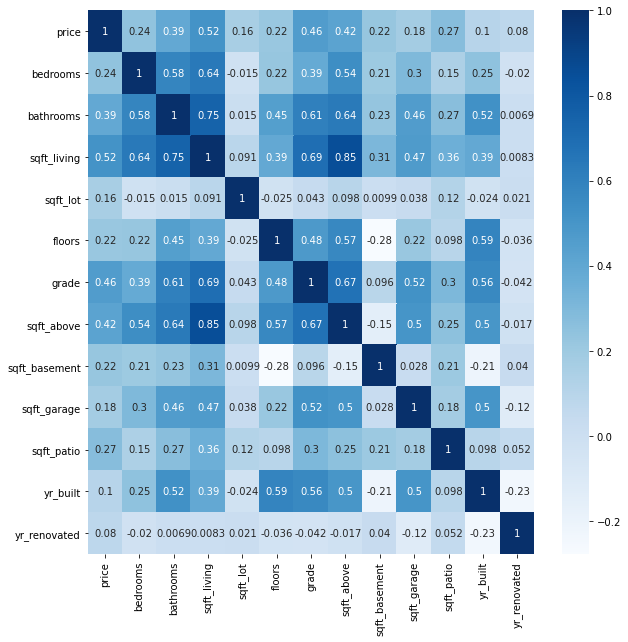

In [34]:
fig, ax = plt.subplots(figsize=(10,10))
cor = low_kc_house.corr()
sns.heatmap(cor,cmap="Blues",annot=True)

Taking another look at what variables had the highest correlation with price.

In [35]:
low_kc_house.corr()['price']

price           1.00
bedrooms        0.24
bathrooms       0.39
sqft_living     0.52
sqft_lot        0.16
floors          0.22
grade           0.46
sqft_above      0.42
sqft_basement   0.22
sqft_garage     0.18
sqft_patio      0.27
yr_built        0.10
yr_renovated    0.08
Name: price, dtype: float64

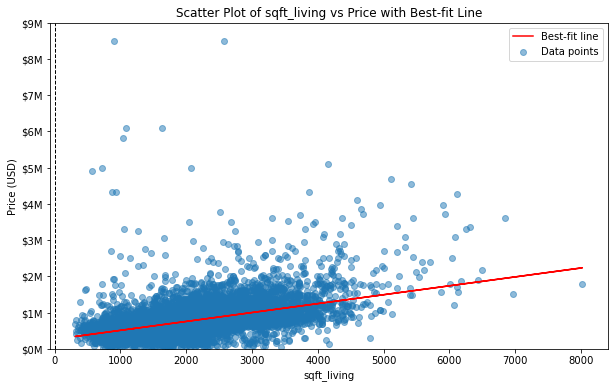

In [36]:
# Perform linear regression
coefficients = np.polyfit(low_kc_house['sqft_living'], low_kc_house['price'], 1)
poly = np.poly1d(coefficients)

# Scatter plot
plt.figure(figsize=(10, 6))
plt.scatter(low_kc_house['sqft_living'], low_kc_house['price'], alpha=0.5, label='Data points')

# Plot the best-fit line
plt.plot(low_kc_house['sqft_living'], poly(low_kc_house['sqft_living']), color='red', label='Best-fit line')

# Title and labels
plt.title('Scatter Plot of sqft_living vs Price with Best-fit Line')
plt.xlabel('sqft_living')
plt.ylabel('Price (USD)')

# Set y-axis limit to show only positive values
plt.ylim(bottom=0)

# Convert y-axis ticks to represent prices in millions
plt.yticks(ticks=plt.yticks()[0], labels=['${:.0f}M'.format(x / 1e6) for x in plt.yticks()[0]])

# Set axis intercept at (0, 0)
plt.axhline(0, color='black', linestyle='--', linewidth=1)
plt.axvline(0, color='black', linestyle='--', linewidth=1)

# Legend
plt.legend()

# Show the plot
plt.show()

Starting the train test split process. I entered my numerical features as my X variables and 'price' against my y variable.

In [37]:
# Define the features (X) and the target variable (y)
X = low_kc_house[['sqft_living','bedrooms','bathrooms','floors','grade','sqft_lot','sqft_above','sqft_garage','sqft_basement','sqft_patio']]
y = low_kc_house['price']


In [38]:
# split the data into training and testing
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2,random_state=42)

In [39]:
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(11544, 10)
(2887, 10)
(11544,)
(2887,)


In [40]:
X.dtypes

sqft_living        int64
bedrooms           int64
bathrooms        float64
floors           float64
grade              int64
sqft_lot           int64
sqft_above         int64
sqft_garage        int64
sqft_basement      int64
sqft_patio         int64
dtype: object

I wanted to create a function so I could easily evaluate each of models with an r2 score, root mean squared error, and mean absolute error.

In [41]:
def evaluate_model(y_test, y_pred, lr):
    # R-squared (R2)
    r2 = r2_score(y_test, y_pred)
    
    # Root Mean Squared Error (RMSE)
    rmse = mean_squared_error(y_test, y_pred, squared=False)
    
    # Mean Absolute Error (MAE)
    mae = mean_absolute_error(y_test, y_pred)
    
    # Intercept
    #intercept = lr.intercept_
    
    # Printing the results
    print("R2 score: ", r2)
    print("Root Mean Squared Error: ", rmse)
    print("Mean Absolute Error: ", mae)
    #print("Intercept: ", intercept)
    
    # Returning the results as a dictionary
    results_model = {
        'r2': r2,
        'rmse': rmse,
        'mae': mae,
        #'intercept': intercept
    }
    
    return results_model

# Modeling

## Baseline Model

In [42]:
baseline_model = sm.OLS(endog=y_train, exog=sm.add_constant(X_train['sqft_living']))
baseline_model

In [43]:
baseline_results = baseline_model.fit()
baseline_results

In [44]:
print(baseline_results.summary())

                            OLS Regression Results                            
Dep. Variable:                  price   R-squared:                       0.263
Model:                            OLS   Adj. R-squared:                  0.263
Method:                 Least Squares   F-statistic:                     4117.
Date:                Mon, 27 Nov 2023   Prob (F-statistic):               0.00
Time:                        21:47:02   Log-Likelihood:            -1.6271e+05
No. Observations:               11544   AIC:                         3.254e+05
Df Residuals:                   11542   BIC:                         3.254e+05
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
const        2.705e+05   7867.698     34.375      

In [45]:
y_pred0 = baseline_results.predict(sm.add_constant(X_test['sqft_living']))
evaluate_model(y_test,y_pred0,baseline_model)

R2 score:  0.27453333546309444
Root Mean Squared Error:  330222.30380844034
Mean Absolute Error:  188870.09638627042


{'r2': 0.27453333546309444,
 'rmse': 330222.30380844034,
 'mae': 188870.09638627042}

The model explains about 26 percent of the variance which is fairly low. This is understandable because there is a lot more that determines the price of a house other than square footage.
The model predicts that an increase of 1 sqft_living is associated with an increase of about 245 USD in price.
The model is statistically significant with a p-value below the standard alpha of 0.05. The testing data is showing a r2 score (variance) of about 27 percent which means there is an ever so slight underfitting issue. The root mean squared error is very high at about $330,000 which is substanstial. The mean absolute error is also very high at about 188,000 USD. It should also be noted that the constant is at about 270,000 USD. This means that the model is being built on this hypothetical floor price which is also very high. We can conclude that although this model performs pretty well it should really not be used for any real world predictions. 

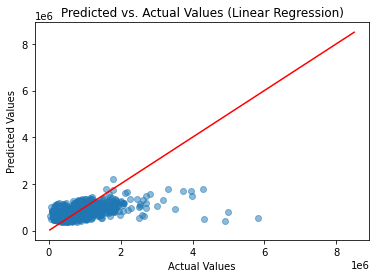

In [46]:
# Plot the predicted vs. actual values

plt.scatter(y_test, y_pred0, alpha=0.5)
plt.plot([y.min(), y.max()], [y.min(), y.max()], color ="red")
plt.xlabel("Actual Values")
plt.ylabel("Predicted Values")
plt.title("Predicted vs. Actual Values (Linear Regression)")
plt.show()

Building a Multiple Linear Regression Model 

In [47]:
X_train[['sqft_living', 'grade']]

,sqft_living,grade
id,,
7300400840,3120,9
3327900100,1800,7
9558020820,1900,8
3224049105,2420,7
4058801085,3110,8
...,...,...
7305300800,1200,6
520079082,3510,9
722069226,2990,7


## Second Model

In [48]:
X = low_kc_house[['sqft_living','bedrooms','bathrooms','floors','grade','sqft_lot','sqft_above','sqft_garage','sqft_basement','sqft_patio']]
X_second = low_kc_house[['sqft_living', 'grade']]
y = low_kc_house['price']

In [49]:
MLR_model = sm.OLS(y_train, sm.add_constant(X_train[['sqft_living', 'grade']]))
second_results = MLR_model.fit()
print(second_results.summary())

                            OLS Regression Results                            
Dep. Variable:                  price   R-squared:                       0.286
Model:                            OLS   Adj. R-squared:                  0.285
Method:                 Least Squares   F-statistic:                     2306.
Date:                Mon, 27 Nov 2023   Prob (F-statistic):               0.00
Time:                        21:47:02   Log-Likelihood:            -1.6253e+05
No. Observations:               11544   AIC:                         3.251e+05
Df Residuals:                   11541   BIC:                         3.251e+05
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
const       -1.786e+05   2.48e+04     -7.217      

In [50]:
# Predict on the testing set
# Y_preds are predicted values of the target variable based on the features
# Once we have those preds, we can compare them to the actual values of the target
# To evaluate the performance of the model
y_pred1 = second_results.predict(sm.add_constant(X_test[['sqft_living', 'grade']]))

In [51]:
evaluate_model(y_test,y_pred1,MLR_model)

R2 score:  0.29719144102045214
Root Mean Squared Error:  325024.5706205458
Mean Absolute Error:  185494.7150060409


{'r2': 0.29719144102045214,
 'rmse': 325024.5706205458,
 'mae': 185494.7150060409}

This model explains about 28.6% on the variance which is again fairly low but slightly better than the baseline model. The model predicts that 1 unit of increase in sqft_living would result in an increase of about 175 dollars in price. One unit of increase in grade predicts about a 79,000 dollar increase in price. The 2 features are statistically significant with low p-values. The testing r2 score is slightly higher at about 29.7% which means the model does have slight fit issues, most likely due to multicolinearity between the features. The root mean squared error is also very high at roughly 325,000 USD which is substantial but important to note that it is around 5,000 USD less than the baseline model. The mean absolute error is around 185,000 USD which is also very high but still roughly $3,000 less than the baseline model. The constant is also lower at roughly 178,000 USD which is almost 100,000 USD less than the baseline model. Although this model does appear to be an improvement it should still not be used for real world predictions.

## Third ''Kitchen Sink" Model

In [52]:
# X = low_kc_house[['sqft_living','bedrooms','bathrooms','floors','grade','sqft_lot','sqft_above','sqft_garage','sqft_basement','sqft_patio']]
# y = low_kc_house['price']

In [53]:
MLR_model2 = sm.OLS(y_train, sm.add_constant(X_train))
third_results = MLR_model2.fit()
print(third_results.summary())

                            OLS Regression Results                            
Dep. Variable:                  price   R-squared:                       0.332
Model:                            OLS   Adj. R-squared:                  0.331
Method:                 Least Squares   F-statistic:                     571.9
Date:                Mon, 27 Nov 2023   Prob (F-statistic):               0.00
Time:                        21:47:02   Log-Likelihood:            -1.6215e+05
No. Observations:               11544   AIC:                         3.243e+05
Df Residuals:                   11533   BIC:                         3.244e+05
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
const         -2.122e+05   2.74e+04     -7.747

In [54]:
# Predict on the testing set
# Y_preds are predicted values of the target variable based on the features
# Once we have those preds, we can compare them to the actual values of the target
# To evaluate the performance of the model
y_pred2 = third_results.predict(sm.add_constant(X_test))

In [55]:
evaluate_model(y_test,y_pred2,MLR_model2)

R2 score:  0.35144510605774015
Root Mean Squared Error:  312227.42168256926
Mean Absolute Error:  176236.20491543153


{'r2': 0.35144510605774015,
 'rmse': 312227.42168256926,
 'mae': 176236.20491543153}

The "kitchen sink" model with all numeric features has a variance of about 33.2% which is again fairly low but also higher than the baseline model. It appears that all the features (with the exception of floors) are statistically significant with very low p-values. The testing r2 score is around 35% which means the model does have fit issues most likely due to multicolinearity between the features. The root mean squared error is very high at around 312,000, however it is has the lowest rmse of the 3 models. The feature Bedrooms has a negative correlation with price at roughly around 41,000 USD for a one unit increase. An example scenario where this would make sense is a new one or 2 bedroom condo in the heart of downtown would be more expensive than a 3 bedroom home in the middle of nowhere away from basic necessities like a grocery store. So we can see that there are some issues with the data. Practically you would think that a 4 bedroom home would be more valuable than a 2 bedroom home and in a lot of scenarios this would be true. This insight shows how truly important location must play a role in the price of a home.

## Evaluation

The "kitchen sink" model is the best performing model. It has the highest variance of the 3 models but it is still fairly low at 33.2%. It has the lowest root mean squared error of the 3 models at roughly 312,000 which is still very large. For these reasons the model should not be used for predictive measures. From the model we did learn that one unit of square footage is approximately equal to to about 128 USD in price. A 1 unit increase in grade is approximately equal to 96,000 USD in price which seems high. It also shows that an additional bathroom is equal to about 17,000 USD in price. These are the features that seem to have the biggest impact on price.

# Conclusion

The "kitchen sink" model is the best performing model. However this model should really not be used for real world predictions. We need to gather a lot more data (hundreds of thousands more entries) specifically in homes in the low median priced zipcode areas. Ideally looking for data that is not so multicolinear so that the regression models can be more useful/predictive. However in the meantime the low median priced zipcodes would be good areas to target. The top zipcode to focus on would be the '98168', '98118', and '98146' areas as it is showing the most homes with a 'fair' or 'low average' grade that in theory would return profits easily with minimal renovations.

# Limitations

The main limitations of this dataset was that there was a lot of multicolinearity between the features of the homes. The features were more correlated with each other rather than the target variable (price). We could see this after looking at a heatmap (Pearson Correlation Coefficient Matrix) and after running each of the models with training/testing data. Although the Linear Regression models were helpful in getting an idea of how features correlate with price the models did not perform well enough to be predictive. Furter the models were only built off around 14,000 entries of data gathering more (10x) along with using features that were not as colinear with each other would benefit the models predictive capabilities greatly.

# Next Steps/Recommendations

We need a lot more data/records (hundreds of thousands) specifically in the zipcodes below the median price for homes in the county. Ideally trying to find features that do not have a lot of multicolinearity. Also obtaining data on schools in the district as well as crime reports in the county would be helpful as the would definitely have an impact on price. This kind of data would not be correlated with standard features of a home. Also gathering other economic data would be beneficial such as if there are major companies close by for work or other shopping plazas/restaurants nearby and how this would affect the price of homes. 